In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/qa-intents-dataset-university-domain/dataset_test.tsv
/kaggle/input/qa-intents-dataset-university-domain/labels_description.txt
/kaggle/input/qa-intents-dataset-university-domain/dataset_train.tsv


In [2]:
train_data = pd.read_csv('../input/qa-intents-dataset-university-domain/dataset_train.tsv',delimiter='\t',encoding="utf-8",names=['text', 'intent'])
test_data = pd.read_csv('../input/qa-intents-dataset-university-domain/dataset_test.tsv',delimiter='\t',encoding="utf-8",names=['text', 'intent'])
train_data.head()

,text,intent
0,мне нужна справка,statement_general
1,оформить справку,statement_general
2,взять справку,statement_general
3,справку как получить,statement_general
4,справку ммф где получаться,statement_general


In [3]:
full_data = pd.concat([train_data, test_data])
full_data.head()

,text,intent
0,мне нужна справка,statement_general
1,оформить справку,statement_general
2,взять справку,statement_general
3,справку как получить,statement_general
4,справку ммф где получаться,statement_general


In [4]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14113 entries, 0 to 882
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    14113 non-null  object
 1   intent  14113 non-null  object
dtypes: object(2)
memory usage: 330.8+ KB


In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(full_data, test_size=0.2, random_state=42)

In [6]:
unique_values_normalized = train['intent'].value_counts(normalize=True)
print(unique_values_normalized*100)

intent
sched_teacher                8.582817
sched_for_group              3.126661
sched_for_group_day          3.046944
wifi                         2.143490
status_free                  2.037201
                               ...   
location_general             0.168291
loc_nsu_cafeteria            0.168291
student_trade_union_enter    0.159433
loc_passport_office          0.159433
staff_trade_union_enter      0.159433
Name: proportion, Length: 142, dtype: float64


In [7]:
unique_values_normalized2 = test['intent'].value_counts(normalize=True)
print(unique_values_normalized2*100)

intent
sched_teacher              7.616011
sched_for_group_day        3.010981
sched_for_group            2.833865
wifi                       2.267092
status_free                2.054552
                             ...   
volunteer_become           0.106270
staff_trade_union_enter    0.106270
cvvr_define                0.106270
nsu_foundation_date        0.070847
location_general           0.070847
Name: proportion, Length: 142, dtype: float64


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2823 entries, 8079 to 8188
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2823 non-null   object
 1   intent  2823 non-null   object
dtypes: object(2)
memory usage: 66.2+ KB


In [9]:
from transformers import BertTokenizer

In [10]:
# Создание токенизатора BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
# Преобразование текста в токены
input_texts = train['text'].values.tolist()  # Преобразуйте тексты в список
input_ids = tokenizer.batch_encode_plus(input_texts, add_special_tokens=True, padding=True, truncation=True, max_length=64, return_tensors='pt')['input_ids']
# labels = torch.tensor(train_data['intent'].values)

In [12]:
# Преобразование меток в числовой формат
unique_intents = train['intent'].unique().tolist()
intent_mapping = {intent: i for i, intent in enumerate(unique_intents)}
train_labels = [intent_mapping[intent] for intent in train['intent']]
test_labels = [intent_mapping[intent] for intent in test['intent']]

In [13]:
import torch
import torch.nn as nn
from transformers import BertForSequenceClassification, AdamW

In [14]:
# Загрузка предобученной модели BERT
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(train_data['intent'].unique()))

# Определение оптимизатора
optimizer = AdamW(model.parameters(), lr=1e-3)

# # Преобразование текста в токены и создание маски внимания
# input_ids = tokenizer.encode(train_data['text'].values, add_special_tokens=True, padding=True, truncation=True, max_length=64, return_tensors='pt')
# #labels = torch.tensor(train_data['intent'].values)

# Преобразование текста в токены и создание маски внимания
encoding = tokenizer.batch_encode_plus(
    train['text'].values.tolist(),  # Преобразуйте тексты в список
    add_special_tokens=True,
    padding=True,
    truncation=True,
    max_length=64,
    return_tensors='pt'
)
input_ids = encoding['input_ids']
attention_mask = encoding['attention_mask']


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
import matplotlib.pyplot as plt

def plot_loss(loss_values):
    plt.plot(loss_values)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

In [16]:
from torch.utils.data import Dataset, DataLoader

class IntentClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Создание DataLoader
def create_data_loader(texts, labels, tokenizer, max_len, batch_size):
    ds = IntentClassificationDataset(
        texts=texts,
        labels=labels,
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size
    )

# Использование DataLoader в вашем коде
batch_size = 8 # 16
max_len = 64
train_data_loader = create_data_loader(train['text'].values.tolist(), train_labels, tokenizer, max_len, batch_size)
test_data_loader = create_data_loader(test['text'].values.tolist(), test_labels, tokenizer, max_len, batch_size)

In [17]:
print(next(iter(train_data_loader)))

{'text': ['математический находится', 'расписание для Кудинов О.В.', 'какой там график военного стола универа плиз', 'находится корпус административный', 'аптечка отыскать', 'где расположен где поликлиника', 'можно ли заплатить онлайн за проживание пожалуйста', 'деканат института философии и права находится'], 'input_ids': tensor([[  101,  1191, 10260, 22919, 15290, 29745, 10260, 22919, 10325, 29752,
         15290, 29747, 23925, 15414,  1192, 10260, 29750, 14150, 29742, 10325,
         22919, 29747, 17432,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0],
        [  101,  1195, 10260, 29747, 29746, 10325, 29747, 28995, 10325, 15290,
          1184, 29436, 17432,  1189, 29748, 29742, 10325, 18947, 19259,  1193,
     

In [18]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, recall_score, f1_score

Epoch 1: 100%|██████████| 1412/1412 [1:06:30<00:00,  2.83s/it]


Epoch: 1, Train Loss: 5.2476


Validation Epoch 1:   0%|          | 1/353 [00:00<04:33,  1.29it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:   1%|          | 2/353 [00:01<04:31,  1.29it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:   1%|          | 3/353 [00:02<04:32,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:   1%|          | 4/353 [00:03<04:31,  1.29it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:   1%|▏         | 5/353 [00:03<04:30,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:   2%|▏         | 6/353 [00:04<04:30,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467196  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:   2%|▏         | 7/353 [00:05<04:29,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:   2%|▏         | 8/353 [00:06<04:28,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:   3%|▎         | 9/353 [00:07<04:27,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:   3%|▎         | 10/353 [00:07<04:28,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:   3%|▎         | 11/353 [00:08<04:27,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:   3%|▎         | 12/353 [00:09<04:30,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:   4%|▎         | 13/353 [00:10<05:18,  1.07it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:   4%|▍         | 14/353 [00:11<05:33,  1.02it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:   4%|▍         | 15/353 [00:12<05:11,  1.09it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:   5%|▍         | 16/353 [00:13<04:55,  1.14it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467196  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:   5%|▍         | 17/353 [00:14<04:45,  1.18it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:   5%|▌         | 18/353 [00:14<04:37,  1.21it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:   5%|▌         | 19/353 [00:15<04:31,  1.23it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:   6%|▌         | 20/353 [00:16<04:26,  1.25it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:   6%|▌         | 21/353 [00:17<04:22,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:   6%|▌         | 22/353 [00:17<04:20,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:   7%|▋         | 23/353 [00:18<04:20,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:   7%|▋         | 24/353 [00:19<04:22,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:   7%|▋         | 25/353 [00:20<04:19,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:   7%|▋         | 26/353 [00:21<04:16,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:   8%|▊         | 27/353 [00:21<04:14,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:   8%|▊         | 28/353 [00:22<04:13,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:   8%|▊         | 29/353 [00:23<04:12,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467196  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:   8%|▊         | 30/353 [00:24<04:11,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:   9%|▉         | 31/353 [00:24<04:10,  1.29it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.4290311  -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:   9%|▉         | 32/353 [00:25<04:09,  1.29it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:   9%|▉         | 33/353 [00:26<04:08,  1.29it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  10%|▉         | 34/353 [00:27<04:08,  1.29it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  10%|▉         | 35/353 [00:28<04:07,  1.29it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  10%|█         | 36/353 [00:28<04:10,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  10%|█         | 37/353 [00:29<04:18,  1.22it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  11%|█         | 38/353 [00:30<04:12,  1.25it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  11%|█         | 39/353 [00:31<04:08,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  11%|█▏        | 40/353 [00:32<04:06,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  12%|█▏        | 41/353 [00:32<04:04,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  12%|█▏        | 42/353 [00:33<04:02,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  12%|█▏        | 43/353 [00:34<04:01,  1.29it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  12%|█▏        | 44/353 [00:35<03:59,  1.29it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467196  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  13%|█▎        | 45/353 [00:35<03:58,  1.29it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  13%|█▎        | 46/353 [00:36<03:57,  1.29it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  13%|█▎        | 47/353 [00:37<03:57,  1.29it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  14%|█▎        | 48/353 [00:38<03:56,  1.29it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  14%|█▍        | 49/353 [00:39<04:00,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  14%|█▍        | 50/353 [00:39<03:58,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  14%|█▍        | 51/353 [00:40<03:57,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  15%|█▍        | 52/353 [00:41<03:55,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  15%|█▌        | 53/353 [00:42<04:16,  1.17it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  15%|█▌        | 54/353 [00:43<04:54,  1.02it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  16%|█▌        | 55/353 [00:44<04:38,  1.07it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  16%|█▌        | 56/353 [00:45<04:23,  1.13it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  16%|█▌        | 57/353 [00:46<04:12,  1.17it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  16%|█▋        | 58/353 [00:46<04:05,  1.20it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  17%|█▋        | 59/353 [00:47<04:00,  1.22it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  17%|█▋        | 60/353 [00:48<03:56,  1.24it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  17%|█▋        | 61/353 [00:49<03:58,  1.23it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  18%|█▊        | 62/353 [00:50<03:54,  1.24it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  18%|█▊        | 63/353 [00:50<03:51,  1.25it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  18%|█▊        | 64/353 [00:51<03:49,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  18%|█▊        | 65/353 [00:52<03:47,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.4290311  -5.742276
  -2.9318085 ]]


Validation Epoch 1:  19%|█▊        | 66/353 [00:53<03:44,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  19%|█▉        | 67/353 [00:54<03:43,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  19%|█▉        | 68/353 [00:54<03:42,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  20%|█▉        | 69/353 [00:55<03:42,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  20%|█▉        | 70/353 [00:56<03:41,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  20%|██        | 71/353 [00:57<03:42,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  20%|██        | 72/353 [00:57<03:40,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  21%|██        | 73/353 [00:58<03:38,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  21%|██        | 74/353 [00:59<03:41,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  21%|██        | 75/353 [01:00<03:49,  1.21it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  22%|██▏       | 76/353 [01:01<03:45,  1.23it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467196  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  22%|██▏       | 77/353 [01:01<03:41,  1.24it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  22%|██▏       | 78/353 [01:02<03:38,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  22%|██▏       | 79/353 [01:03<03:36,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  23%|██▎       | 80/353 [01:04<03:34,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  23%|██▎       | 81/353 [01:05<03:33,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  23%|██▎       | 82/353 [01:05<03:31,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  24%|██▎       | 83/353 [01:06<03:30,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  24%|██▍       | 84/353 [01:07<03:29,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  24%|██▍       | 85/353 [01:08<03:27,  1.29it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  24%|██▍       | 86/353 [01:09<03:30,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  25%|██▍       | 87/353 [01:09<03:28,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  25%|██▍       | 88/353 [01:10<03:27,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467196  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  25%|██▌       | 89/353 [01:11<03:26,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  25%|██▌       | 90/353 [01:12<03:25,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  26%|██▌       | 91/353 [01:12<03:24,  1.28it/s]

[[-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  26%|██▌       | 92/353 [01:13<03:23,  1.29it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  26%|██▋       | 93/353 [01:14<03:28,  1.25it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  27%|██▋       | 94/353 [01:15<04:04,  1.06it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  27%|██▋       | 95/353 [01:16<04:06,  1.05it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  27%|██▋       | 96/353 [01:17<03:51,  1.11it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  27%|██▋       | 97/353 [01:18<03:40,  1.16it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  28%|██▊       | 98/353 [01:19<03:36,  1.18it/s]

[[-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467196  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  28%|██▊       | 99/353 [01:19<03:30,  1.21it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  28%|██▊       | 100/353 [01:20<03:25,  1.23it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  29%|██▊       | 101/353 [01:21<03:21,  1.25it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  29%|██▉       | 102/353 [01:22<03:18,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  29%|██▉       | 103/353 [01:23<03:16,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  29%|██▉       | 104/353 [01:23<03:15,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  30%|██▉       | 105/353 [01:24<03:13,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  30%|███       | 106/353 [01:25<03:12,  1.29it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  30%|███       | 107/353 [01:26<03:10,  1.29it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  31%|███       | 108/353 [01:26<03:10,  1.29it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  31%|███       | 109/353 [01:27<03:09,  1.29it/s]

[[-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  31%|███       | 110/353 [01:28<03:08,  1.29it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  31%|███▏      | 111/353 [01:29<03:11,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  32%|███▏      | 112/353 [01:30<03:09,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  32%|███▏      | 113/353 [01:30<03:15,  1.23it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  32%|███▏      | 114/353 [01:31<03:12,  1.24it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  33%|███▎      | 115/353 [01:32<03:09,  1.25it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  33%|███▎      | 116/353 [01:33<03:06,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  33%|███▎      | 117/353 [01:34<03:05,  1.27it/s]

[[-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  33%|███▎      | 118/353 [01:34<03:04,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  34%|███▎      | 119/353 [01:35<03:03,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  34%|███▍      | 120/353 [01:36<03:02,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  34%|███▍      | 121/353 [01:37<03:00,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  35%|███▍      | 122/353 [01:37<02:59,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  35%|███▍      | 123/353 [01:38<02:59,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  35%|███▌      | 124/353 [01:39<03:01,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  35%|███▌      | 125/353 [01:40<02:59,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  36%|███▌      | 126/353 [01:41<02:58,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  36%|███▌      | 127/353 [01:41<02:58,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  36%|███▋      | 128/353 [01:42<02:56,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  37%|███▋      | 129/353 [01:43<02:56,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  37%|███▋      | 130/353 [01:44<02:54,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  37%|███▋      | 131/353 [01:45<02:53,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467196  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  37%|███▋      | 132/353 [01:45<02:52,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  38%|███▊      | 133/353 [01:46<02:52,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  38%|███▊      | 134/353 [01:47<03:16,  1.11it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  38%|███▊      | 135/353 [01:48<03:38,  1.00s/it]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  39%|███▊      | 136/353 [01:49<03:22,  1.07it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  39%|███▉      | 137/353 [01:50<03:11,  1.13it/s]

[[-0.13467196  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  39%|███▉      | 138/353 [01:51<03:03,  1.17it/s]

[[-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  39%|███▉      | 139/353 [01:52<02:58,  1.20it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  40%|███▉      | 140/353 [01:52<02:54,  1.22it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  40%|███▉      | 141/353 [01:53<02:50,  1.24it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  40%|████      | 142/353 [01:54<02:48,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  41%|████      | 143/353 [01:55<02:45,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  41%|████      | 144/353 [01:56<02:44,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  41%|████      | 145/353 [01:56<02:44,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  41%|████▏     | 146/353 [01:57<02:43,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  42%|████▏     | 147/353 [01:58<02:42,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  42%|████▏     | 148/353 [01:59<02:43,  1.25it/s]

[[-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  42%|████▏     | 149/353 [01:59<02:42,  1.26it/s]

[[-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  42%|████▏     | 150/353 [02:00<02:40,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  43%|████▎     | 151/353 [02:01<02:45,  1.22it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  43%|████▎     | 152/353 [02:02<02:42,  1.24it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  43%|████▎     | 153/353 [02:03<02:40,  1.25it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  44%|████▎     | 154/353 [02:04<02:38,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  44%|████▍     | 155/353 [02:04<02:36,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  44%|████▍     | 156/353 [02:05<02:34,  1.27it/s]

[[-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  44%|████▍     | 157/353 [02:06<02:33,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  45%|████▍     | 158/353 [02:07<02:32,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  45%|████▌     | 159/353 [02:07<02:31,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  45%|████▌     | 160/353 [02:08<02:31,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467196  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  46%|████▌     | 161/353 [02:09<02:32,  1.26it/s]

[[-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  46%|████▌     | 162/353 [02:10<02:31,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  46%|████▌     | 163/353 [02:11<02:29,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  46%|████▋     | 164/353 [02:11<02:28,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  47%|████▋     | 165/353 [02:12<02:27,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  47%|████▋     | 166/353 [02:13<02:26,  1.28it/s]

[[-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  47%|████▋     | 167/353 [02:14<02:25,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  48%|████▊     | 168/353 [02:14<02:24,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  48%|████▊     | 169/353 [02:15<02:24,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  48%|████▊     | 170/353 [02:16<02:23,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  48%|████▊     | 171/353 [02:17<02:22,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  49%|████▊     | 172/353 [02:18<02:20,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  49%|████▉     | 173/353 [02:18<02:22,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  49%|████▉     | 174/353 [02:19<02:36,  1.14it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  50%|████▉     | 175/353 [02:21<02:57,  1.00it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  50%|████▉     | 176/353 [02:22<02:45,  1.07it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  50%|█████     | 177/353 [02:22<02:36,  1.13it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  50%|█████     | 178/353 [02:23<02:29,  1.17it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  51%|█████     | 179/353 [02:24<02:24,  1.20it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  51%|█████     | 180/353 [02:25<02:20,  1.23it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  51%|█████▏    | 181/353 [02:25<02:18,  1.24it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  52%|█████▏    | 182/353 [02:26<02:16,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  52%|█████▏    | 183/353 [02:27<02:14,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  52%|█████▏    | 184/353 [02:28<02:12,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  52%|█████▏    | 185/353 [02:29<02:13,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467196  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  53%|█████▎    | 186/353 [02:29<02:12,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  53%|█████▎    | 187/353 [02:30<02:10,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  53%|█████▎    | 188/353 [02:31<02:09,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  54%|█████▎    | 189/353 [02:32<02:14,  1.22it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  54%|█████▍    | 190/353 [02:33<02:11,  1.24it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  54%|█████▍    | 191/353 [02:33<02:09,  1.25it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  54%|█████▍    | 192/353 [02:34<02:07,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  55%|█████▍    | 193/353 [02:35<02:06,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  55%|█████▍    | 194/353 [02:36<02:04,  1.27it/s]

[[-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  55%|█████▌    | 195/353 [02:36<02:03,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  56%|█████▌    | 196/353 [02:37<02:02,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  56%|█████▌    | 197/353 [02:38<02:02,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  56%|█████▌    | 198/353 [02:39<02:03,  1.25it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  56%|█████▋    | 199/353 [02:40<02:01,  1.26it/s]

[[-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  57%|█████▋    | 200/353 [02:40<02:00,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  57%|█████▋    | 201/353 [02:41<01:59,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  57%|█████▋    | 202/353 [02:42<01:58,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  58%|█████▊    | 203/353 [02:43<01:57,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  58%|█████▊    | 204/353 [02:44<01:56,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  58%|█████▊    | 205/353 [02:44<01:55,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  58%|█████▊    | 206/353 [02:45<01:54,  1.29it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  59%|█████▊    | 207/353 [02:46<01:53,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  59%|█████▉    | 208/353 [02:47<01:52,  1.28it/s]

[[-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  59%|█████▉    | 209/353 [02:47<01:52,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  59%|█████▉    | 210/353 [02:48<01:51,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  60%|█████▉    | 211/353 [02:49<01:52,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  60%|██████    | 212/353 [02:50<01:51,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  60%|██████    | 213/353 [02:51<01:49,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  61%|██████    | 214/353 [02:51<01:53,  1.23it/s]

[[-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  61%|██████    | 215/353 [02:53<02:11,  1.05it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  61%|██████    | 216/353 [02:54<02:03,  1.11it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  61%|██████▏   | 217/353 [02:54<01:57,  1.16it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  62%|██████▏   | 218/353 [02:55<01:52,  1.20it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467196  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  62%|██████▏   | 219/353 [02:56<01:49,  1.22it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  62%|██████▏   | 220/353 [02:57<01:47,  1.24it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  63%|██████▎   | 221/353 [02:57<01:45,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  63%|██████▎   | 222/353 [02:58<01:43,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  63%|██████▎   | 223/353 [02:59<01:43,  1.25it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  63%|██████▎   | 224/353 [03:00<01:42,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  64%|██████▎   | 225/353 [03:01<01:41,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  64%|██████▍   | 226/353 [03:01<01:39,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  64%|██████▍   | 227/353 [03:02<01:43,  1.22it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  65%|██████▍   | 228/353 [03:03<01:40,  1.24it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  65%|██████▍   | 229/353 [03:04<01:39,  1.25it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  65%|██████▌   | 230/353 [03:05<01:37,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  65%|██████▌   | 231/353 [03:05<01:36,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  66%|██████▌   | 232/353 [03:06<01:35,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  66%|██████▌   | 233/353 [03:07<01:33,  1.28it/s]

[[-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  66%|██████▋   | 234/353 [03:08<01:33,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  67%|██████▋   | 235/353 [03:09<01:33,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  67%|██████▋   | 236/353 [03:09<01:32,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  67%|██████▋   | 237/353 [03:10<01:31,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  67%|██████▋   | 238/353 [03:11<01:30,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  68%|██████▊   | 239/353 [03:12<01:29,  1.28it/s]

[[-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  68%|██████▊   | 240/353 [03:12<01:28,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  68%|██████▊   | 241/353 [03:13<01:27,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  69%|██████▊   | 242/353 [03:14<01:26,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  69%|██████▉   | 243/353 [03:15<01:25,  1.29it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  69%|██████▉   | 244/353 [03:16<01:24,  1.29it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  69%|██████▉   | 245/353 [03:16<01:24,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  70%|██████▉   | 246/353 [03:17<01:23,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  70%|██████▉   | 247/353 [03:18<01:22,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467196  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  70%|███████   | 248/353 [03:19<01:23,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  71%|███████   | 249/353 [03:19<01:22,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  71%|███████   | 250/353 [03:20<01:20,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  71%|███████   | 251/353 [03:21<01:19,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  71%|███████▏  | 252/353 [03:22<01:18,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  72%|███████▏  | 253/353 [03:23<01:17,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  72%|███████▏  | 254/353 [03:24<01:24,  1.17it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  72%|███████▏  | 255/353 [03:25<01:36,  1.01it/s]

[[-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  73%|███████▎  | 256/353 [03:26<01:30,  1.07it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  73%|███████▎  | 257/353 [03:27<01:25,  1.12it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  73%|███████▎  | 258/353 [03:27<01:21,  1.17it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  73%|███████▎  | 259/353 [03:28<01:18,  1.20it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  74%|███████▎  | 260/353 [03:29<01:17,  1.20it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  74%|███████▍  | 261/353 [03:30<01:15,  1.22it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  74%|███████▍  | 262/353 [03:30<01:13,  1.24it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  75%|███████▍  | 263/353 [03:31<01:12,  1.25it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  75%|███████▍  | 264/353 [03:32<01:10,  1.25it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  75%|███████▌  | 265/353 [03:33<01:13,  1.19it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  75%|███████▌  | 266/353 [03:34<01:11,  1.22it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  76%|███████▌  | 267/353 [03:35<01:09,  1.24it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  76%|███████▌  | 268/353 [03:35<01:07,  1.25it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  76%|███████▌  | 269/353 [03:36<01:06,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  76%|███████▋  | 270/353 [03:37<01:05,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  77%|███████▋  | 271/353 [03:38<01:04,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  77%|███████▋  | 272/353 [03:38<01:04,  1.25it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  77%|███████▋  | 273/353 [03:39<01:03,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  78%|███████▊  | 274/353 [03:40<01:02,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  78%|███████▊  | 275/353 [03:41<01:01,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  78%|███████▊  | 276/353 [03:42<01:00,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  78%|███████▊  | 277/353 [03:42<00:59,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  79%|███████▉  | 278/353 [03:43<00:58,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  79%|███████▉  | 279/353 [03:44<00:57,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  79%|███████▉  | 280/353 [03:45<00:56,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  80%|███████▉  | 281/353 [03:45<00:56,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  80%|███████▉  | 282/353 [03:46<00:55,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  80%|████████  | 283/353 [03:47<00:54,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  80%|████████  | 284/353 [03:48<00:53,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  81%|████████  | 285/353 [03:49<00:54,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  81%|████████  | 286/353 [03:49<00:52,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.4290311  -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  81%|████████▏ | 287/353 [03:50<00:51,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  82%|████████▏ | 288/353 [03:51<00:50,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  82%|████████▏ | 289/353 [03:52<00:50,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  82%|████████▏ | 290/353 [03:53<00:49,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  82%|████████▏ | 291/353 [03:53<00:48,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  83%|████████▎ | 292/353 [03:54<00:47,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  83%|████████▎ | 293/353 [03:55<00:46,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  83%|████████▎ | 294/353 [03:56<00:48,  1.21it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  84%|████████▎ | 295/353 [03:57<00:55,  1.04it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  84%|████████▍ | 296/353 [03:58<00:54,  1.05it/s]

[[-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  84%|████████▍ | 297/353 [03:59<00:51,  1.09it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  84%|████████▍ | 298/353 [04:00<00:48,  1.14it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  85%|████████▍ | 299/353 [04:00<00:45,  1.18it/s]

[[-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  85%|████████▍ | 300/353 [04:01<00:43,  1.21it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  85%|████████▌ | 301/353 [04:02<00:42,  1.23it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  86%|████████▌ | 302/353 [04:03<00:40,  1.24it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  86%|████████▌ | 303/353 [04:04<00:41,  1.19it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  86%|████████▌ | 304/353 [04:04<00:40,  1.22it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  86%|████████▋ | 305/353 [04:05<00:38,  1.24it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  87%|████████▋ | 306/353 [04:06<00:37,  1.25it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  87%|████████▋ | 307/353 [04:07<00:36,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  87%|████████▋ | 308/353 [04:08<00:35,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  88%|████████▊ | 309/353 [04:08<00:35,  1.25it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  88%|████████▊ | 310/353 [04:09<00:34,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  88%|████████▊ | 311/353 [04:10<00:33,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  88%|████████▊ | 312/353 [04:11<00:32,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  89%|████████▊ | 313/353 [04:12<00:31,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  89%|████████▉ | 314/353 [04:12<00:30,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  89%|████████▉ | 315/353 [04:13<00:29,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  90%|████████▉ | 316/353 [04:14<00:29,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  90%|████████▉ | 317/353 [04:15<00:28,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  90%|█████████ | 318/353 [04:15<00:27,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  90%|█████████ | 319/353 [04:16<00:26,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  91%|█████████ | 320/353 [04:17<00:25,  1.29it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  91%|█████████ | 321/353 [04:18<00:24,  1.29it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467196  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  91%|█████████ | 322/353 [04:19<00:24,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  92%|█████████▏| 323/353 [04:19<00:23,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  92%|█████████▏| 324/353 [04:20<00:22,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  92%|█████████▏| 325/353 [04:21<00:21,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  92%|█████████▏| 326/353 [04:22<00:21,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  93%|█████████▎| 327/353 [04:23<00:20,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  93%|█████████▎| 328/353 [04:23<00:19,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  93%|█████████▎| 329/353 [04:24<00:18,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467196  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  93%|█████████▎| 330/353 [04:25<00:17,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  94%|█████████▍| 331/353 [04:26<00:17,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  94%|█████████▍| 332/353 [04:26<00:16,  1.28it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467196  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  94%|█████████▍| 333/353 [04:27<00:15,  1.28it/s]

[[-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  95%|█████████▍| 334/353 [04:28<00:15,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  95%|█████████▍| 335/353 [04:29<00:16,  1.06it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  95%|█████████▌| 336/353 [04:30<00:16,  1.03it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  95%|█████████▌| 337/353 [04:31<00:14,  1.09it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  96%|█████████▌| 338/353 [04:32<00:13,  1.14it/s]

[[-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  96%|█████████▌| 339/353 [04:33<00:11,  1.18it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  96%|█████████▋| 340/353 [04:33<00:10,  1.21it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  97%|█████████▋| 341/353 [04:34<00:10,  1.17it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.4290311  -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  97%|█████████▋| 342/353 [04:35<00:09,  1.20it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  97%|█████████▋| 343/353 [04:36<00:08,  1.22it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  97%|█████████▋| 344/353 [04:37<00:07,  1.24it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  98%|█████████▊| 345/353 [04:38<00:06,  1.25it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  98%|█████████▊| 346/353 [04:38<00:05,  1.25it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  98%|█████████▊| 347/353 [04:39<00:04,  1.24it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  99%|█████████▊| 348/353 [04:40<00:03,  1.25it/s]

[[-0.13467193  2.850816   -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  99%|█████████▉| 349/353 [04:41<00:03,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  99%|█████████▉| 350/353 [04:41<00:02,  1.26it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1:  99%|█████████▉| 351/353 [04:42<00:01,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1: 100%|█████████▉| 352/353 [04:43<00:00,  1.27it/s]

[[-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 ...
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]
 [-0.13467193  2.8508158  -2.9000514  ... -3.429031   -5.742276
  -2.9318085 ]]


Validation Epoch 1: 100%|██████████| 353/353 [04:44<00:00,  1.24it/s]


[[-0.13467191  2.8508158  -2.900051   -2.086069    0.4591957   0.18932348
   1.1639348  -2.2196007  -1.6276405  -0.01428054 -0.3585635   0.5006149
   0.31159374  0.70321     0.73634773  0.87300867  2.0437405   0.7855034
   0.97985005 -0.11367194  0.6334167  -4.0493307  -2.975021    1.4931545
   1.5650669  -2.6122615   0.42417893  0.29279888  2.144113   -2.0247817
  -1.6057975   1.1108032  -0.23985891 -0.3926155  -2.3848429   2.0957189
   0.63261795  2.7142582   0.15815593 -1.7128857  -3.0513098   0.87448716
  -1.7904499  -1.6225212  -1.213183   -4.0756726  -1.2864394  -2.2083836
  -1.1053946  -1.8303552  -2.412547   -0.15881959 -1.6690258  -0.9635859
  -2.7725706   0.61498666 -2.2725165   1.9624108  -3.823495    0.09637886
  -0.17682597  0.7750681  -0.6261722  -0.01345546  0.9267387   2.2005095
  -3.2968102   0.6957395   1.4100419  -0.49111196  0.30226594 -0.84173816
  -1.8468182  -0.6717874  -0.40985668 -1.0498464  -0.70264345 -3.3832808
  -2.3018723  -3.6662235  -3.4119468  -4.425936

Epoch 2: 100%|██████████| 1412/1412 [1:09:36<00:00,  2.96s/it]


Epoch: 2, Train Loss: 5.2447


Validation Epoch 2:   0%|          | 1/353 [00:00<04:32,  1.29it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]]


Validation Epoch 2:   1%|          | 2/353 [00:01<04:31,  1.29it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:   1%|          | 3/353 [00:02<04:30,  1.29it/s]

[[ 0.7789896   2.7433429  -1.5966123  ... -3.3447595  -4.1246996
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.1246996
  -3.4583628 ]]


Validation Epoch 2:   1%|          | 4/353 [00:03<04:30,  1.29it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898973  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:   1%|▏         | 5/353 [00:03<04:29,  1.29it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:   2%|▏         | 6/353 [00:04<04:28,  1.29it/s]

[[ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789897  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583626]
 ...
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447595 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]]


Validation Epoch 2:   2%|▏         | 7/353 [00:05<04:27,  1.29it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:   2%|▏         | 8/353 [00:06<04:26,  1.29it/s]

[[ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447595  -4.124699
  -3.4583628 ]]


Validation Epoch 2:   3%|▎         | 9/353 [00:07<04:51,  1.18it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.1246986
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.77898973  2.7433429  -1.5966123  ... -3.3447595  -4.1246986
  -3.4583626 ]]


Validation Epoch 2:   3%|▎         | 10/353 [00:08<05:38,  1.01it/s]

[[ 0.7789897   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:   3%|▎         | 11/353 [00:09<05:21,  1.06it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:   3%|▎         | 12/353 [00:10<05:03,  1.12it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447595  -4.1246986
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:   4%|▎         | 13/353 [00:10<04:50,  1.17it/s]

[[ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:   4%|▍         | 14/353 [00:11<04:41,  1.20it/s]

[[ 0.77898955  2.7433429  -1.5966126  ... -3.3447597  -4.1246986
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:   4%|▍         | 15/353 [00:12<04:35,  1.23it/s]

[[ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.1246986 -3.4583628]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 ...
 [ 0.7789896  2.7433429 -1.5966122 ... -3.3447597 -4.1246986 -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966123 ... -3.3447597 -4.1246996 -3.4583626]]


Validation Epoch 2:   5%|▍         | 16/353 [00:13<04:30,  1.25it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]]


Validation Epoch 2:   5%|▍         | 17/353 [00:13<04:26,  1.26it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447595  -4.124699
  -3.4583628 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:   5%|▌         | 18/353 [00:14<04:23,  1.27it/s]

[[ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:   5%|▌         | 19/353 [00:15<04:21,  1.28it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447597  -4.1246996
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:   6%|▌         | 20/353 [00:16<04:19,  1.28it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.1246986
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:   6%|▌         | 21/353 [00:17<04:18,  1.29it/s]

[[ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.1246996
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:   6%|▌         | 22/353 [00:17<04:17,  1.29it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:   7%|▋         | 23/353 [00:18<04:20,  1.27it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:   7%|▋         | 24/353 [00:19<04:18,  1.27it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:   7%|▋         | 25/353 [00:20<04:17,  1.28it/s]

[[ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898973  2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:   7%|▋         | 26/353 [00:21<04:39,  1.17it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:   8%|▊         | 27/353 [00:22<04:30,  1.20it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]]


Validation Epoch 2:   8%|▊         | 28/353 [00:22<04:25,  1.23it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.1246986
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]]


Validation Epoch 2:   8%|▊         | 29/353 [00:23<04:20,  1.24it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447595  -4.124699
  -3.4583626 ]]


Validation Epoch 2:   8%|▊         | 30/353 [00:24<04:16,  1.26it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:   9%|▉         | 31/353 [00:25<04:13,  1.27it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.1246986
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]]


Validation Epoch 2:   9%|▉         | 32/353 [00:25<04:11,  1.28it/s]

[[ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:   9%|▉         | 33/353 [00:26<04:09,  1.28it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966126  ... -3.3447595  -4.1246986
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.1246986
  -3.4583626 ]]


Validation Epoch 2:  10%|▉         | 34/353 [00:27<04:08,  1.28it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447595  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  10%|▉         | 35/353 [00:28<04:08,  1.28it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  10%|█         | 36/353 [00:29<04:10,  1.26it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.77898955  2.7433426  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.1246996
  -3.4583626 ]]


Validation Epoch 2:  10%|█         | 37/353 [00:29<04:08,  1.27it/s]

[[ 0.7789897   2.7433429  -1.5966126  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  11%|█         | 38/353 [00:30<04:07,  1.27it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  11%|█         | 39/353 [00:31<04:07,  1.27it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966122  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.1246996
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  11%|█▏        | 40/353 [00:32<04:05,  1.28it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898973  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  12%|█▏        | 41/353 [00:32<04:04,  1.28it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  12%|█▏        | 42/353 [00:33<04:02,  1.28it/s]

[[ 0.7789896  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 ...
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]]


Validation Epoch 2:  12%|█▏        | 43/353 [00:34<04:01,  1.29it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]]


Validation Epoch 2:  12%|█▏        | 44/353 [00:35<03:59,  1.29it/s]

[[ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898973  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  13%|█▎        | 45/353 [00:36<03:58,  1.29it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  13%|█▎        | 46/353 [00:36<03:58,  1.29it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  13%|█▎        | 47/353 [00:37<03:57,  1.29it/s]

[[ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447595  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966126  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447595  -4.1246996
  -3.4583626 ]
 [ 0.77898973  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  14%|█▎        | 48/353 [00:38<04:00,  1.27it/s]

[[ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433426  -1.5966122  ... -3.3447597  -4.1246996
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  14%|█▍        | 49/353 [00:39<04:05,  1.24it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  14%|█▍        | 50/353 [00:40<04:47,  1.05it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  14%|█▍        | 51/353 [00:41<04:52,  1.03it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898973  2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  15%|█▍        | 52/353 [00:42<04:33,  1.10it/s]

[[ 0.7789897  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 ...
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]]


Validation Epoch 2:  15%|█▌        | 53/353 [00:43<04:20,  1.15it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  15%|█▌        | 54/353 [00:43<04:11,  1.19it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  16%|█▌        | 55/353 [00:44<04:04,  1.22it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447595  -4.1246986
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898973  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  16%|█▌        | 56/353 [00:45<03:59,  1.24it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447595  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  16%|█▌        | 57/353 [00:46<03:55,  1.26it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966122  ... -3.3447595  -4.1246986
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]]


Validation Epoch 2:  16%|█▋        | 58/353 [00:46<03:52,  1.27it/s]

[[ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 ...
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966122 ... -3.3447597 -4.124699  -3.4583626]]


Validation Epoch 2:  17%|█▋        | 59/353 [00:47<03:50,  1.27it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  17%|█▋        | 60/353 [00:48<03:52,  1.26it/s]

[[ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447595 -4.124699  -3.4583626]
 ...
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]]


Validation Epoch 2:  17%|█▋        | 61/353 [00:49<03:50,  1.27it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433426  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  18%|█▊        | 62/353 [00:50<03:48,  1.27it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  18%|█▊        | 63/353 [00:50<03:47,  1.27it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  18%|█▊        | 64/353 [00:51<04:07,  1.17it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  18%|█▊        | 65/353 [00:52<03:59,  1.20it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898973  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  19%|█▊        | 66/353 [00:53<03:54,  1.23it/s]

[[ 0.7789896  2.7433429 -1.5966125 ... -3.3447595 -4.1246986 -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.1246986 -3.4583626]
 ...
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966122 ... -3.3447597 -4.124699  -3.4583628]]


Validation Epoch 2:  19%|█▉        | 67/353 [00:54<03:49,  1.24it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433426  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.458363  ]]


Validation Epoch 2:  19%|█▉        | 68/353 [00:55<03:46,  1.26it/s]

[[ 0.7789896  2.7433429 -1.5966125 ... -3.3447595 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.1246986 -3.4583626]
 ...
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.1246986 -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]]


Validation Epoch 2:  20%|█▉        | 69/353 [00:55<03:44,  1.26it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  20%|█▉        | 70/353 [00:56<03:42,  1.27it/s]

[[ 0.77898955  2.7433429  -1.5966123  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.1246986
  -3.4583626 ]]


Validation Epoch 2:  20%|██        | 71/353 [00:57<03:40,  1.28it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  20%|██        | 72/353 [00:58<03:39,  1.28it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  21%|██        | 73/353 [00:58<03:42,  1.26it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  21%|██        | 74/353 [00:59<03:40,  1.27it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966126  ... -3.3447595  -4.1246986
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  21%|██        | 75/353 [01:00<03:38,  1.27it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447595  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  22%|██▏       | 76/353 [01:01<03:36,  1.28it/s]

[[ 0.7789897   2.7433429  -1.5966122  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433426  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  22%|██▏       | 77/353 [01:02<03:35,  1.28it/s]

[[ 0.7789896  2.7433429 -1.5966125 ... -3.3447595 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583626]
 ...
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966122 ... -3.3447595 -4.1246986 -3.4583626]
 [ 0.7789897  2.7433429 -1.5966122 ... -3.3447597 -4.124699  -3.4583626]]


Validation Epoch 2:  22%|██▏       | 78/353 [01:02<03:34,  1.28it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  22%|██▏       | 79/353 [01:03<03:33,  1.28it/s]

[[ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433426 -1.5966123 ... -3.3447597 -4.1246996 -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 ...
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447595 -4.124699  -3.4583628]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]]


Validation Epoch 2:  23%|██▎       | 80/353 [01:04<03:32,  1.28it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  23%|██▎       | 81/353 [01:05<03:31,  1.29it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.1246986
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  23%|██▎       | 82/353 [01:05<03:30,  1.29it/s]

[[ 0.7789896   2.7433429  -1.5966123  ... -3.3447595  -4.1246996
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  24%|██▎       | 83/353 [01:06<03:29,  1.29it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]]


Validation Epoch 2:  24%|██▍       | 84/353 [01:07<03:29,  1.29it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  24%|██▍       | 85/353 [01:08<03:31,  1.27it/s]

[[ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 ...
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]]


Validation Epoch 2:  24%|██▍       | 86/353 [01:09<03:30,  1.27it/s]

[[ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 ...
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]]


Validation Epoch 2:  25%|██▍       | 87/353 [01:09<03:29,  1.27it/s]

[[ 0.77898955  2.7433426  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898973  2.7433429  -1.5966123  ... -3.3447597  -4.1246996
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433426  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  25%|██▍       | 88/353 [01:10<03:27,  1.27it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  25%|██▌       | 89/353 [01:11<03:26,  1.28it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.1246996
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]]


Validation Epoch 2:  25%|██▌       | 90/353 [01:12<04:01,  1.09it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  26%|██▌       | 91/353 [01:13<04:16,  1.02it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447595  -4.1246996
  -3.4583626 ]]


Validation Epoch 2:  26%|██▌       | 92/353 [01:14<04:00,  1.09it/s]

[[ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.1246986 -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447595 -4.124699  -3.4583628]
 ...
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966123 ... -3.3447597 -4.1246996 -3.4583626]
 [ 0.7789896  2.7433429 -1.5966126 ... -3.3447597 -4.124699  -3.4583626]]


Validation Epoch 2:  26%|██▋       | 93/353 [01:15<03:47,  1.14it/s]

[[ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  27%|██▋       | 94/353 [01:16<03:39,  1.18it/s]

[[ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]]


Validation Epoch 2:  27%|██▋       | 95/353 [01:16<03:33,  1.21it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583626 ]]


Validation Epoch 2:  27%|██▋       | 96/353 [01:17<03:28,  1.23it/s]

[[ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 ...
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.1246986 -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]]


Validation Epoch 2:  27%|██▋       | 97/353 [01:18<03:27,  1.23it/s]

[[ 0.7789896  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 ...
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966122 ... -3.3447597 -4.1246996 -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]]


Validation Epoch 2:  28%|██▊       | 98/353 [01:19<03:24,  1.25it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.1246996
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  28%|██▊       | 99/353 [01:20<03:21,  1.26it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  28%|██▊       | 100/353 [01:20<03:18,  1.27it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  29%|██▊       | 101/353 [01:21<03:17,  1.28it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]]


Validation Epoch 2:  29%|██▉       | 102/353 [01:22<03:34,  1.17it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  29%|██▉       | 103/353 [01:23<03:27,  1.21it/s]

[[ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966126  ... -3.3447595  -4.1246986
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  29%|██▉       | 104/353 [01:24<03:22,  1.23it/s]

[[ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898973  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.1246996
  -3.4583626 ]]


Validation Epoch 2:  30%|██▉       | 105/353 [01:24<03:19,  1.24it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433426  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  30%|███       | 106/353 [01:25<03:16,  1.25it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  30%|███       | 107/353 [01:26<03:15,  1.26it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  31%|███       | 108/353 [01:27<03:12,  1.27it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966126  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.1246986
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  31%|███       | 109/353 [01:28<03:11,  1.27it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  31%|███       | 110/353 [01:28<03:14,  1.25it/s]

[[ 0.7789897  2.7433429 -1.5966125 ... -3.3447595 -4.124699  -3.4583628]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 ...
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447595 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]]


Validation Epoch 2:  31%|███▏      | 111/353 [01:29<03:11,  1.26it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898973  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  32%|███▏      | 112/353 [01:30<03:10,  1.27it/s]

[[ 0.7789896   2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.1246986
  -3.4583628 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  32%|███▏      | 113/353 [01:31<03:08,  1.27it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  32%|███▏      | 114/353 [01:32<03:06,  1.28it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  33%|███▎      | 115/353 [01:32<03:05,  1.28it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  33%|███▎      | 116/353 [01:33<03:04,  1.28it/s]

[[ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.1246986 -3.4583626]
 [ 0.7789896  2.7433429 -1.5966122 ... -3.3447597 -4.124699  -3.4583626]
 ...
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]]


Validation Epoch 2:  33%|███▎      | 117/353 [01:34<03:03,  1.28it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  33%|███▎      | 118/353 [01:35<03:02,  1.29it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966126  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  34%|███▎      | 119/353 [01:35<03:01,  1.29it/s]

[[ 0.7789897   2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  34%|███▍      | 120/353 [01:36<03:01,  1.29it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447595  -4.1246986
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447595  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  34%|███▍      | 121/353 [01:37<02:59,  1.29it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  35%|███▍      | 122/353 [01:38<02:59,  1.28it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.1246986
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  35%|███▍      | 123/353 [01:39<03:01,  1.27it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966126  ... -3.3447597  -4.1246986
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433429  -1.5966126  ... -3.3447595  -4.1246986
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  35%|███▌      | 124/353 [01:39<02:59,  1.27it/s]

[[ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433426 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 ...
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]]


Validation Epoch 2:  35%|███▌      | 125/353 [01:40<02:58,  1.27it/s]

[[ 0.7789896   2.7433429  -1.5966122  ... -3.3447595  -4.1246996
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  36%|███▌      | 126/353 [01:41<02:57,  1.28it/s]

[[ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433426  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  36%|███▌      | 127/353 [01:42<02:56,  1.28it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898973  2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  36%|███▋      | 128/353 [01:42<02:55,  1.28it/s]

[[ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 ...
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966122 ... -3.3447597 -4.124699  -3.4583626]]


Validation Epoch 2:  37%|███▋      | 129/353 [01:43<02:54,  1.28it/s]

[[ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583626]
 ...
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.1246986 -3.4583626]
 [ 0.7789897  2.7433429 -1.5966122 ... -3.3447597 -4.124699  -3.4583628]]


Validation Epoch 2:  37%|███▋      | 130/353 [01:44<03:15,  1.14it/s]

[[ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 ...
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.1246986 -3.4583626]]


Validation Epoch 2:  37%|███▋      | 131/353 [01:46<03:38,  1.01it/s]

[[ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.1246986 -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 ...
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.1246996 -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]]


Validation Epoch 2:  37%|███▋      | 132/353 [01:46<03:24,  1.08it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  38%|███▊      | 133/353 [01:47<03:13,  1.14it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  38%|███▊      | 134/353 [01:48<03:09,  1.16it/s]

[[ 0.7789897  2.7433429 -1.5966125 ... -3.3447595 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.1246996 -3.4583626]
 ...
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447595 -4.124699  -3.4583626]]


Validation Epoch 2:  38%|███▊      | 135/353 [01:49<03:02,  1.19it/s]

[[ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  39%|███▊      | 136/353 [01:49<02:57,  1.22it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  39%|███▉      | 137/353 [01:50<02:53,  1.24it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.1246986
  -3.4583628 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  39%|███▉      | 138/353 [01:51<02:51,  1.26it/s]

[[ 0.7789897  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966126 ... -3.3447595 -4.1246996 -3.4583626]
 ...
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]]


Validation Epoch 2:  39%|███▉      | 139/353 [01:52<02:49,  1.27it/s]

[[ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.1246986
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  40%|███▉      | 140/353 [01:53<03:05,  1.15it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583626 ]]


Validation Epoch 2:  40%|███▉      | 141/353 [01:54<02:58,  1.19it/s]

[[ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.1246996
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.1246986
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  40%|████      | 142/353 [01:54<02:53,  1.22it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  41%|████      | 143/353 [01:55<02:49,  1.24it/s]

[[ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447595 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447595 -4.124699  -3.4583626]
 ...
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.1246986 -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]]


Validation Epoch 2:  41%|████      | 144/353 [01:56<02:46,  1.25it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  41%|████      | 145/353 [01:57<02:44,  1.26it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  41%|████▏     | 146/353 [01:58<02:43,  1.27it/s]

[[ 0.77898955  2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  42%|████▏     | 147/353 [01:58<02:44,  1.25it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  42%|████▏     | 148/353 [01:59<02:42,  1.26it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  42%|████▏     | 149/353 [02:00<02:40,  1.27it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  42%|████▏     | 150/353 [02:01<02:38,  1.28it/s]

[[ 0.7789897   2.7433429  -1.5966122  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  43%|████▎     | 151/353 [02:01<02:37,  1.28it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.77898955  2.7433426  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  43%|████▎     | 152/353 [02:02<02:36,  1.29it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  43%|████▎     | 153/353 [02:03<02:35,  1.29it/s]

[[ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  44%|████▎     | 154/353 [02:04<02:34,  1.29it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966123  ... -3.34476    -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583626 ]]


Validation Epoch 2:  44%|████▍     | 155/353 [02:05<02:33,  1.29it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  44%|████▍     | 156/353 [02:05<02:32,  1.29it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433426  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.1246986
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  44%|████▍     | 157/353 [02:06<02:31,  1.29it/s]

[[ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  45%|████▍     | 158/353 [02:07<02:31,  1.29it/s]

[[ 0.77898955  2.7433426  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  45%|████▌     | 159/353 [02:08<02:30,  1.29it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.1246986
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  45%|████▌     | 160/353 [02:08<02:32,  1.27it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  46%|████▌     | 161/353 [02:09<02:31,  1.27it/s]

[[ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  46%|████▌     | 162/353 [02:10<02:29,  1.28it/s]

[[ 0.77898955  2.7433426  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898973  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  46%|████▌     | 163/353 [02:11<02:28,  1.28it/s]

[[ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  46%|████▋     | 164/353 [02:12<02:27,  1.28it/s]

[[ 0.77898955  2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433426  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  47%|████▋     | 165/353 [02:12<02:26,  1.29it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  47%|████▋     | 166/353 [02:13<02:25,  1.29it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  47%|████▋     | 167/353 [02:14<02:24,  1.29it/s]

[[ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  48%|████▊     | 168/353 [02:15<02:23,  1.29it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  48%|████▊     | 169/353 [02:15<02:22,  1.29it/s]

[[ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433426  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447595  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  48%|████▊     | 170/353 [02:16<02:32,  1.20it/s]

[[ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  48%|████▊     | 171/353 [02:18<02:51,  1.06it/s]

[[ 0.7789897  2.7433429 -1.5966125 ... -3.3447595 -4.1246986 -3.4583628]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 ...
 [ 0.7789897  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]]


Validation Epoch 2:  49%|████▊     | 172/353 [02:18<02:44,  1.10it/s]

[[ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  49%|████▉     | 173/353 [02:19<02:36,  1.15it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]]


Validation Epoch 2:  49%|████▉     | 174/353 [02:20<02:30,  1.19it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447595  -4.1246986
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  50%|████▉     | 175/353 [02:21<02:26,  1.21it/s]

[[ 0.7789896  2.7433429 -1.5966122 ... -3.3447595 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966126 ... -3.3447597 -4.1246986 -3.4583628]
 [ 0.7789896  2.7433429 -1.5966122 ... -3.3447597 -4.1246986 -3.4583626]
 ...
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]]


Validation Epoch 2:  50%|████▉     | 176/353 [02:22<02:23,  1.23it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  50%|█████     | 177/353 [02:22<02:21,  1.25it/s]

[[ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966123 ... -3.3447597 -4.1246986 -3.4583626]
 [ 0.7789896  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583628]
 ...
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966126 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583626]]


Validation Epoch 2:  50%|█████     | 178/353 [02:23<02:32,  1.15it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  51%|█████     | 179/353 [02:24<02:26,  1.19it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447595  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  51%|█████     | 180/353 [02:25<02:22,  1.22it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.1246996
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  51%|█████▏    | 181/353 [02:26<02:19,  1.24it/s]

[[ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 ...
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447595 -4.1246986 -3.4583628]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]]


Validation Epoch 2:  52%|█████▏    | 182/353 [02:26<02:16,  1.25it/s]

[[ 0.7789896   2.7433426  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  52%|█████▏    | 183/353 [02:27<02:14,  1.26it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966126  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  52%|█████▏    | 184/353 [02:28<02:15,  1.25it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  52%|█████▏    | 185/353 [02:29<02:13,  1.26it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  53%|█████▎    | 186/353 [02:30<02:11,  1.27it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  53%|█████▎    | 187/353 [02:30<02:10,  1.27it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966126  ... -3.3447597  -4.1246996
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  53%|█████▎    | 188/353 [02:31<02:09,  1.27it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  54%|█████▎    | 189/353 [02:32<02:08,  1.27it/s]

[[ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447595 -4.124699  -3.4583626]
 ...
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]]


Validation Epoch 2:  54%|█████▍    | 190/353 [02:33<02:07,  1.27it/s]

[[ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966126  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  54%|█████▍    | 191/353 [02:34<02:06,  1.28it/s]

[[ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966122 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447595 -4.124699  -3.4583628]
 ...
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]]


Validation Epoch 2:  54%|█████▍    | 192/353 [02:34<02:05,  1.28it/s]

[[ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447595 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447595 -4.124699  -3.4583626]
 ...
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966123 ... -3.3447595 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447595 -4.1246986 -3.4583626]]


Validation Epoch 2:  55%|█████▍    | 193/353 [02:35<02:04,  1.29it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.1246996
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  55%|█████▍    | 194/353 [02:36<02:03,  1.29it/s]

[[ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.1246986 -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.1246986 -3.4583626]
 ...
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.1246986 -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]]


Validation Epoch 2:  55%|█████▌    | 195/353 [02:37<02:02,  1.29it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  56%|█████▌    | 196/353 [02:37<02:01,  1.29it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  56%|█████▌    | 197/353 [02:38<02:02,  1.27it/s]

[[ 0.7789896  2.7433429 -1.5966123 ... -3.3447595 -4.1246986 -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 ...
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]]


Validation Epoch 2:  56%|█████▌    | 198/353 [02:39<02:01,  1.28it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  56%|█████▋    | 199/353 [02:40<02:00,  1.28it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  57%|█████▋    | 200/353 [02:41<01:58,  1.29it/s]

[[ 0.7789897   2.7433429  -1.5966123  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  57%|█████▋    | 201/353 [02:41<01:58,  1.29it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789898   2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433426  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  57%|█████▋    | 202/353 [02:42<01:57,  1.29it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  58%|█████▊    | 203/353 [02:43<01:56,  1.29it/s]

[[ 0.7789896  2.7433429 -1.5966122 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447595 -4.124699  -3.4583626]
 ...
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447595 -4.1246986 -3.4583626]]


Validation Epoch 2:  58%|█████▊    | 204/353 [02:44<01:55,  1.29it/s]

[[ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  58%|█████▊    | 205/353 [02:44<01:54,  1.29it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  58%|█████▊    | 206/353 [02:45<01:53,  1.29it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.1246986
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.1246996
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  59%|█████▊    | 207/353 [02:46<01:53,  1.29it/s]

[[ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 ...
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]]


Validation Epoch 2:  59%|█████▉    | 208/353 [02:47<01:52,  1.29it/s]

[[ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  59%|█████▉    | 209/353 [02:48<01:51,  1.29it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583628 ]]


Validation Epoch 2:  59%|█████▉    | 210/353 [02:49<02:06,  1.13it/s]

[[ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 ...
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]]


Validation Epoch 2:  60%|█████▉    | 211/353 [02:50<02:19,  1.02it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.1246986
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  60%|██████    | 212/353 [02:51<02:10,  1.08it/s]

[[ 0.7789896  2.7433429 -1.5966123 ... -3.3447597 -4.1246996 -3.4583626]
 [ 0.7789896  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447595 -4.124699  -3.4583626]
 ...
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]]


Validation Epoch 2:  60%|██████    | 213/353 [02:51<02:03,  1.14it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  61%|██████    | 214/353 [02:52<01:57,  1.18it/s]

[[ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 ...
 [ 0.7789896  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.1246986 -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]]


Validation Epoch 2:  61%|██████    | 215/353 [02:53<01:54,  1.21it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  61%|██████    | 216/353 [02:54<02:02,  1.12it/s]

[[ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 ...
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447595 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.1246986 -3.4583626]]


Validation Epoch 2:  61%|██████▏   | 217/353 [02:55<01:56,  1.17it/s]

[[ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966122 ... -3.3447595 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447595 -4.124699  -3.4583626]
 ...
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447595 -4.1246986 -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447595 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]]


Validation Epoch 2:  62%|██████▏   | 218/353 [02:56<01:52,  1.20it/s]

[[ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  62%|██████▏   | 219/353 [02:56<01:49,  1.23it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583626 ]]


Validation Epoch 2:  62%|██████▏   | 220/353 [02:57<01:46,  1.24it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  63%|██████▎   | 221/353 [02:58<01:46,  1.23it/s]

[[ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966126  ... -3.3447595  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433429  -1.5966126  ... -3.3447595  -4.1246986
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  63%|██████▎   | 222/353 [02:59<01:44,  1.25it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  63%|██████▎   | 223/353 [03:00<01:43,  1.26it/s]

[[ 0.7789897   2.7433429  -1.5966123  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447595  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  63%|██████▎   | 224/353 [03:00<01:41,  1.27it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447595  -4.1246986
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  64%|██████▎   | 225/353 [03:01<01:40,  1.27it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447595  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  64%|██████▍   | 226/353 [03:02<01:39,  1.28it/s]

[[ 0.7789896  2.7433429 -1.5966125 ... -3.3447595 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.1246986 -3.4583626]
 ...
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447595 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]]


Validation Epoch 2:  64%|██████▍   | 227/353 [03:03<01:38,  1.28it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  65%|██████▍   | 228/353 [03:03<01:37,  1.29it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  65%|██████▍   | 229/353 [03:04<01:36,  1.29it/s]

[[ 0.7789897   2.7433429  -1.5966122  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433426  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  65%|██████▌   | 230/353 [03:05<01:35,  1.29it/s]

[[ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447595 -4.124699  -3.4583626]
 ...
 [ 0.7789896  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583628]]


Validation Epoch 2:  65%|██████▌   | 231/353 [03:06<01:34,  1.29it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.1246996
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  66%|██████▌   | 232/353 [03:06<01:34,  1.28it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  66%|██████▌   | 233/353 [03:07<01:33,  1.29it/s]

[[ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  66%|██████▋   | 234/353 [03:08<01:33,  1.27it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  67%|██████▋   | 235/353 [03:09<01:32,  1.27it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  67%|██████▋   | 236/353 [03:10<01:31,  1.27it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]]


Validation Epoch 2:  67%|██████▋   | 237/353 [03:10<01:30,  1.28it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433426  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433426  -1.5966122  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.77898973  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  67%|██████▋   | 238/353 [03:11<01:29,  1.28it/s]

[[ 0.7789896  2.7433426 -1.5966122 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 ...
 [ 0.7789896  2.7433429 -1.5966122 ... -3.3447597 -4.1246996 -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.1246986 -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]]


Validation Epoch 2:  68%|██████▊   | 239/353 [03:12<01:28,  1.29it/s]

[[ 0.7789896  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966122 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966122 ... -3.3447597 -4.124699  -3.4583626]
 ...
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.1246986 -3.4583628]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447595 -4.124699  -3.4583626]]


Validation Epoch 2:  68%|██████▊   | 240/353 [03:13<01:27,  1.29it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  68%|██████▊   | 241/353 [03:14<01:27,  1.29it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]]


Validation Epoch 2:  69%|██████▊   | 242/353 [03:14<01:25,  1.29it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.1246996
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898973  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  69%|██████▉   | 243/353 [03:15<01:25,  1.29it/s]

[[ 0.7789896   2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  69%|██████▉   | 244/353 [03:16<01:24,  1.29it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433426  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898973  2.7433429  -1.5966123  ... -3.3447595  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  69%|██████▉   | 245/353 [03:17<01:24,  1.28it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.1246986
  -3.4583628 ]]


Validation Epoch 2:  70%|██████▉   | 246/353 [03:17<01:23,  1.28it/s]

[[ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  70%|██████▉   | 247/353 [03:18<01:23,  1.26it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  70%|███████   | 248/353 [03:19<01:22,  1.27it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  71%|███████   | 249/353 [03:20<01:21,  1.27it/s]

[[ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  71%|███████   | 250/353 [03:21<01:28,  1.17it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  71%|███████   | 251/353 [03:22<01:40,  1.02it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  71%|███████▏  | 252/353 [03:23<01:34,  1.07it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.1246986
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  72%|███████▏  | 253/353 [03:24<01:28,  1.13it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  72%|███████▏  | 254/353 [03:25<01:32,  1.07it/s]

[[ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 ...
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.1246986 -3.4583626]
 [ 0.7789896  2.7433429 -1.5966122 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583628]]


Validation Epoch 2:  72%|███████▏  | 255/353 [03:26<01:26,  1.13it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 ...
 [ 0.77898973  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]]


Validation Epoch 2:  73%|███████▎  | 256/353 [03:26<01:22,  1.17it/s]

[[ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447595  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  73%|███████▎  | 257/353 [03:27<01:19,  1.20it/s]

[[ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966126  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  73%|███████▎  | 258/353 [03:28<01:18,  1.20it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.1246986
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  73%|███████▎  | 259/353 [03:29<01:16,  1.22it/s]

[[ 0.7789897  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 ...
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]]


Validation Epoch 2:  74%|███████▎  | 260/353 [03:29<01:14,  1.24it/s]

[[ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966123 ... -3.3447595 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.1246996 -3.4583626]
 ...
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]]


Validation Epoch 2:  74%|███████▍  | 261/353 [03:30<01:13,  1.25it/s]

[[ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  74%|███████▍  | 262/353 [03:31<01:12,  1.26it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.1246996
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  75%|███████▍  | 263/353 [03:32<01:11,  1.27it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  75%|███████▍  | 264/353 [03:33<01:09,  1.27it/s]

[[ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 ...
 [ 0.7789897  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]]


Validation Epoch 2:  75%|███████▌  | 265/353 [03:33<01:08,  1.28it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966126  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  75%|███████▌  | 266/353 [03:34<01:07,  1.28it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  76%|███████▌  | 267/353 [03:35<01:06,  1.28it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 ...
 [ 0.77898955  2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  76%|███████▌  | 268/353 [03:36<01:06,  1.28it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  76%|███████▌  | 269/353 [03:36<01:05,  1.29it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.1246986
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  76%|███████▋  | 270/353 [03:37<01:04,  1.29it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.77898955  2.7433426  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  77%|███████▋  | 271/353 [03:38<01:04,  1.26it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  77%|███████▋  | 272/353 [03:39<01:03,  1.27it/s]

[[ 0.7789897  2.7433429 -1.5966126 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 ...
 [ 0.7789897  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]]


Validation Epoch 2:  77%|███████▋  | 273/353 [03:40<01:02,  1.27it/s]

[[ 0.7789897  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.1246986 -3.4583626]
 ...
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447595 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]]


Validation Epoch 2:  78%|███████▊  | 274/353 [03:40<01:01,  1.28it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]]


Validation Epoch 2:  78%|███████▊  | 275/353 [03:41<01:01,  1.28it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  78%|███████▊  | 276/353 [03:42<01:00,  1.28it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966126  ... -3.3447595  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  78%|███████▊  | 277/353 [03:43<00:59,  1.28it/s]

[[ 0.7789896  2.7433429 -1.5966125 ... -3.3447595 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789897  2.7433429 -1.5966123 ... -3.3447597 -4.1246986 -3.4583626]
 ...
 [ 0.7789896  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966122 ... -3.3447597 -4.124699  -3.4583626]]


Validation Epoch 2:  79%|███████▉  | 278/353 [03:44<00:58,  1.28it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]]


Validation Epoch 2:  79%|███████▉  | 279/353 [03:44<00:57,  1.28it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 ...
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898973  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  79%|███████▉  | 280/353 [03:45<00:56,  1.29it/s]

[[ 0.7789897   2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789897   2.7433426  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.1246986
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  80%|███████▉  | 281/353 [03:46<00:55,  1.29it/s]

[[ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]]


Validation Epoch 2:  80%|███████▉  | 282/353 [03:47<00:55,  1.29it/s]

[[ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  80%|████████  | 283/353 [03:47<00:54,  1.29it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.1246996
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  80%|████████  | 284/353 [03:48<00:54,  1.27it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  81%|████████  | 285/353 [03:49<00:53,  1.27it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  81%|████████  | 286/353 [03:50<00:52,  1.28it/s]

[[ 0.7789896   2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  81%|████████▏ | 287/353 [03:51<00:51,  1.28it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966126  ... -3.3447597  -4.1246986
  -3.4583626 ]]


Validation Epoch 2:  82%|████████▏ | 288/353 [03:51<00:50,  1.28it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  82%|████████▏ | 289/353 [03:52<00:49,  1.28it/s]

[[ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  82%|████████▏ | 290/353 [03:53<00:52,  1.21it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  82%|████████▏ | 291/353 [03:54<00:59,  1.04it/s]

[[ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966123 ... -3.3447595 -4.124699  -3.4583626]
 ...
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]]


Validation Epoch 2:  83%|████████▎ | 292/353 [03:55<00:57,  1.06it/s]

[[ 0.7789897  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966123 ... -3.3447595 -4.124699  -3.4583626]
 ...
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966122 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966126 ... -3.3447597 -4.124699  -3.4583626]]


Validation Epoch 2:  83%|████████▎ | 293/353 [03:56<00:58,  1.02it/s]

[[ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  83%|████████▎ | 294/353 [03:57<00:54,  1.09it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  84%|████████▎ | 295/353 [03:58<00:51,  1.13it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.77898973  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  84%|████████▍ | 296/353 [03:59<00:48,  1.17it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.34476    -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.1246996
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  84%|████████▍ | 297/353 [03:59<00:46,  1.21it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583628 ]]


Validation Epoch 2:  84%|████████▍ | 298/353 [04:00<00:44,  1.23it/s]

[[ 0.7789896  2.7433429 -1.5966122 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 ...
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.1246986 -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.1246996 -3.4583626]]


Validation Epoch 2:  85%|████████▍ | 299/353 [04:01<00:43,  1.24it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  85%|████████▍ | 300/353 [04:02<00:42,  1.25it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447595  -4.1246986
  -3.4583626 ]]


Validation Epoch 2:  85%|████████▌ | 301/353 [04:03<00:41,  1.26it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  86%|████████▌ | 302/353 [04:03<00:40,  1.27it/s]

[[ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 ...
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789898  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]]


Validation Epoch 2:  86%|████████▌ | 303/353 [04:04<00:39,  1.27it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  86%|████████▌ | 304/353 [04:05<00:38,  1.28it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  86%|████████▋ | 305/353 [04:06<00:37,  1.28it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789897   2.7433426  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]]


Validation Epoch 2:  87%|████████▋ | 306/353 [04:06<00:36,  1.28it/s]

[[ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.458363  ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  87%|████████▋ | 307/353 [04:07<00:35,  1.28it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447595  -4.124699
  -3.4583628 ]
 ...
 [ 0.77898973  2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966126  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  87%|████████▋ | 308/353 [04:08<00:35,  1.26it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  88%|████████▊ | 309/353 [04:09<00:34,  1.27it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433426  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.1246986
  -3.4583628 ]]


Validation Epoch 2:  88%|████████▊ | 310/353 [04:10<00:33,  1.27it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433426  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  88%|████████▊ | 311/353 [04:10<00:32,  1.28it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.1246996
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]]


Validation Epoch 2:  88%|████████▊ | 312/353 [04:11<00:32,  1.28it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.1246986
  -3.4583628 ]]


Validation Epoch 2:  89%|████████▊ | 313/353 [04:12<00:31,  1.28it/s]

[[ 0.7789896   2.7433429  -1.5966123  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  89%|████████▉ | 314/353 [04:13<00:30,  1.28it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  89%|████████▉ | 315/353 [04:13<00:29,  1.29it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.1246986
  -3.4583626 ]]


Validation Epoch 2:  90%|████████▉ | 316/353 [04:14<00:28,  1.29it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]]


Validation Epoch 2:  90%|████████▉ | 317/353 [04:15<00:27,  1.29it/s]

[[ 0.7789897   2.7433429  -1.5966122  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.1246986
  -3.4583626 ]]


Validation Epoch 2:  90%|█████████ | 318/353 [04:16<00:27,  1.29it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.1246986
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  90%|█████████ | 319/353 [04:17<00:26,  1.29it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433426  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.1246986
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.77898973  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  91%|█████████ | 320/353 [04:17<00:25,  1.29it/s]

[[ 0.7789897  2.7433429 -1.5966126 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966126 ... -3.3447595 -4.1246986 -3.4583628]
 ...
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966122 ... -3.3447597 -4.124699  -3.4583626]]


Validation Epoch 2:  91%|█████████ | 321/353 [04:18<00:25,  1.25it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  91%|█████████ | 322/353 [04:19<00:24,  1.26it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  92%|█████████▏| 323/353 [04:20<00:23,  1.27it/s]

[[ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966122  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  92%|█████████▏| 324/353 [04:21<00:22,  1.28it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  92%|█████████▏| 325/353 [04:21<00:21,  1.28it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]]


Validation Epoch 2:  92%|█████████▏| 326/353 [04:22<00:21,  1.28it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  93%|█████████▎| 327/353 [04:23<00:20,  1.28it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  93%|█████████▎| 328/353 [04:24<00:19,  1.28it/s]

[[ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  93%|█████████▎| 329/353 [04:24<00:18,  1.28it/s]

[[ 0.77898955  2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  93%|█████████▎| 330/353 [04:25<00:18,  1.24it/s]

[[ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 ...
 [ 0.7789896  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966126 ... -3.3447597 -4.124699  -3.4583626]]


Validation Epoch 2:  94%|█████████▍| 331/353 [04:27<00:20,  1.05it/s]

[[ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 ...
 [ 0.7789897  2.7433429 -1.5966122 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]]


Validation Epoch 2:  94%|█████████▍| 332/353 [04:28<00:20,  1.01it/s]

[[ 0.7789897   2.7433429  -1.5966122  ... -3.3447597  -4.1246996
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.1246986
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.1246996
  -3.4583626 ]]


Validation Epoch 2:  94%|█████████▍| 333/353 [04:29<00:18,  1.07it/s]

[[ 0.7789897  2.7433429 -1.5966123 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966122 ... -3.3447597 -4.124699  -3.4583626]
 ...
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447595 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447595 -4.124699  -3.4583626]]


Validation Epoch 2:  95%|█████████▍| 334/353 [04:29<00:16,  1.12it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  95%|█████████▍| 335/353 [04:30<00:15,  1.17it/s]

[[ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583628]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 ...
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447595 -4.124699  -3.4583628]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.1246986 -3.4583626]]


Validation Epoch 2:  95%|█████████▌| 336/353 [04:31<00:14,  1.21it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  95%|█████████▌| 337/353 [04:32<00:13,  1.23it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433426  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.1246986
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  96%|█████████▌| 338/353 [04:32<00:12,  1.25it/s]

[[ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966123 ... -3.3447595 -4.124699  -3.4583628]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 ...
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.1246986 -3.4583628]
 [ 0.7789896  2.7433429 -1.5966123 ... -3.3447597 -4.1246996 -3.4583626]
 [ 0.7789897  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]]


Validation Epoch 2:  96%|█████████▌| 339/353 [04:33<00:11,  1.26it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  96%|█████████▋| 340/353 [04:34<00:10,  1.27it/s]

[[ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 ...
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789896  2.7433429 -1.5966125 ... -3.3447597 -4.124699  -3.4583626]
 [ 0.7789897  2.7433429 -1.5966122 ... -3.3447597 -4.124699  -3.4583628]]


Validation Epoch 2:  97%|█████████▋| 341/353 [04:35<00:09,  1.27it/s]

[[ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]]


Validation Epoch 2:  97%|█████████▋| 342/353 [04:35<00:08,  1.28it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.1246996
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  97%|█████████▋| 343/353 [04:36<00:07,  1.28it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.77898973  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  97%|█████████▋| 344/353 [04:37<00:07,  1.28it/s]

[[ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.1246996
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966126  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  98%|█████████▊| 345/353 [04:38<00:06,  1.26it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.1246996
  -3.4583626 ]]


Validation Epoch 2:  98%|█████████▊| 346/353 [04:39<00:05,  1.26it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447595  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  98%|█████████▊| 347/353 [04:39<00:04,  1.27it/s]

[[ 0.7789897   2.7433429  -1.5966126  ... -3.3447597  -4.1246986
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583628 ]]


Validation Epoch 2:  99%|█████████▊| 348/353 [04:40<00:03,  1.27it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.1246996
  -3.4583628 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  99%|█████████▉| 349/353 [04:41<00:03,  1.27it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.1246986
  -3.4583626 ]
 ...
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  99%|█████████▉| 350/353 [04:42<00:02,  1.28it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966123  ... -3.3447595  -4.124699
  -3.4583628 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.1246986
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966123  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2:  99%|█████████▉| 351/353 [04:43<00:01,  1.28it/s]

[[ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.124699
  -3.4583628 ]]


Validation Epoch 2: 100%|█████████▉| 352/353 [04:43<00:00,  1.28it/s]

[[ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789897   2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]
 ...
 [ 0.77898955  2.7433429  -1.5966122  ... -3.3447597  -4.124699
  -3.4583626 ]
 [ 0.7789896   2.7433429  -1.5966125  ... -3.3447595  -4.1246996
  -3.4583628 ]
 [ 0.7789897   2.7433429  -1.5966125  ... -3.3447597  -4.124699
  -3.4583626 ]]


Validation Epoch 2: 100%|██████████| 353/353 [04:44<00:00,  1.24it/s]


[[ 0.7789897   2.7433429  -1.5966126  -1.4360515   0.24721438 -0.25118402
   0.8656339  -1.9106154  -1.7407243  -0.20892271  0.11830156 -0.16760176
   0.9557393  -0.10156137  0.37625772 -0.5786981   2.2595117  -0.08732566
   0.51701325 -0.59019965  0.7044763  -4.3053603  -3.0585232   0.9969662
   1.2517201  -0.9639423   0.32146913  0.18979698  1.6749953  -2.3986752
  -1.706945    1.1971833  -0.31110924 -0.35941377 -2.1357625   2.5044334
   0.04673186  2.32831    -0.19479984 -1.9089601  -2.1018653   0.19883847
  -2.4956853  -1.8044889  -0.66179734 -5.7012124  -1.1987904  -2.0232174
  -1.0845513  -3.7608624  -2.8676798  -0.18288583 -1.3207462  -0.35259175
  -3.0254612  -0.41878837 -2.492629    1.6168048  -1.8206415  -1.0717475
  -1.2755718   0.17697252 -0.65246475 -0.6038499   0.8033622   2.1518283
  -4.1482363   0.2868532   0.99792826 -1.0952042   0.1053853   0.49180484
  -1.4803005  -1.0641882  -1.4102802  -0.25121617 -1.0808125  -3.216435
  -0.89929867 -4.392271   -3.288466   -3.41919

Epoch 3: 100%|██████████| 1412/1412 [1:14:20<00:00,  3.16s/it]


Epoch: 3, Train Loss: 5.2988


Validation Epoch 3:   0%|          | 1/353 [00:00<04:33,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:   1%|          | 2/353 [00:01<04:44,  1.23it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:   1%|          | 3/353 [00:02<05:58,  1.02s/it]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:   1%|          | 4/353 [00:04<06:15,  1.08s/it]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:   1%|▏         | 5/353 [00:04<05:37,  1.03it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:   2%|▏         | 6/353 [00:05<05:14,  1.10it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:   2%|▏         | 7/353 [00:06<04:58,  1.16it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:   2%|▏         | 8/353 [00:07<04:48,  1.20it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:   3%|▎         | 9/353 [00:07<04:40,  1.22it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:   3%|▎         | 10/353 [00:08<04:36,  1.24it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:   3%|▎         | 11/353 [00:09<04:32,  1.25it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:   3%|▎         | 12/353 [00:10<04:30,  1.26it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:   4%|▎         | 13/353 [00:11<04:27,  1.27it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:   4%|▍         | 14/353 [00:11<04:25,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:   4%|▍         | 15/353 [00:12<04:23,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:   5%|▍         | 16/353 [00:13<04:23,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:   5%|▍         | 17/353 [00:14<04:25,  1.26it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:   5%|▌         | 18/353 [00:14<04:22,  1.27it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:   5%|▌         | 19/353 [00:15<04:20,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:   6%|▌         | 20/353 [00:16<04:20,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:   6%|▌         | 21/353 [00:17<04:19,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:   6%|▌         | 22/353 [00:18<04:17,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:   7%|▋         | 23/353 [00:18<04:16,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:   7%|▋         | 24/353 [00:19<04:16,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:   7%|▋         | 25/353 [00:20<04:15,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:   7%|▋         | 26/353 [00:21<04:14,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:   8%|▊         | 27/353 [00:21<04:13,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:   8%|▊         | 28/353 [00:22<04:12,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:   8%|▊         | 29/353 [00:23<04:16,  1.26it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:   8%|▊         | 30/353 [00:24<04:14,  1.27it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:   9%|▉         | 31/353 [00:25<04:11,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:   9%|▉         | 32/353 [00:25<04:09,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:   9%|▉         | 33/353 [00:26<04:07,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  10%|▉         | 34/353 [00:27<04:06,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  10%|▉         | 35/353 [00:28<04:04,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  10%|█         | 36/353 [00:28<04:04,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  10%|█         | 37/353 [00:29<04:04,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  11%|█         | 38/353 [00:30<04:03,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  11%|█         | 39/353 [00:31<04:02,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  11%|█▏        | 40/353 [00:32<04:01,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  12%|█▏        | 41/353 [00:32<04:00,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  12%|█▏        | 42/353 [00:33<04:04,  1.27it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  12%|█▏        | 43/353 [00:34<04:47,  1.08it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  12%|█▏        | 44/353 [00:36<05:09,  1.00s/it]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  13%|█▎        | 45/353 [00:36<04:47,  1.07it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  13%|█▎        | 46/353 [00:37<04:31,  1.13it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  13%|█▎        | 47/353 [00:38<04:20,  1.18it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  14%|█▎        | 48/353 [00:39<04:10,  1.22it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  14%|█▍        | 49/353 [00:39<04:05,  1.24it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  14%|█▍        | 50/353 [00:40<04:01,  1.26it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  14%|█▍        | 51/353 [00:41<03:58,  1.27it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  15%|█▍        | 52/353 [00:42<03:55,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  15%|█▌        | 53/353 [00:42<03:54,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  15%|█▌        | 54/353 [00:43<03:57,  1.26it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  16%|█▌        | 55/353 [00:44<03:55,  1.27it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  16%|█▌        | 56/353 [00:45<03:53,  1.27it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  16%|█▌        | 57/353 [00:46<03:51,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  16%|█▋        | 58/353 [00:46<03:50,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  17%|█▋        | 59/353 [00:47<03:48,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  17%|█▋        | 60/353 [00:48<03:47,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  17%|█▋        | 61/353 [00:49<03:46,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  18%|█▊        | 62/353 [00:50<03:45,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  18%|█▊        | 63/353 [00:50<03:44,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  18%|█▊        | 64/353 [00:51<03:43,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  18%|█▊        | 65/353 [00:52<03:42,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  19%|█▊        | 66/353 [00:53<03:41,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  19%|█▉        | 67/353 [00:53<03:43,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  19%|█▉        | 68/353 [00:54<03:41,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  20%|█▉        | 69/353 [00:55<03:40,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  20%|█▉        | 70/353 [00:56<03:38,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  20%|██        | 71/353 [00:56<03:36,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  20%|██        | 72/353 [00:57<03:35,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  21%|██        | 73/353 [00:58<03:34,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  21%|██        | 74/353 [00:59<03:34,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  21%|██        | 75/353 [01:00<03:33,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  22%|██▏       | 76/353 [01:00<03:32,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  22%|██▏       | 77/353 [01:01<03:32,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  22%|██▏       | 78/353 [01:02<03:31,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  22%|██▏       | 79/353 [01:03<03:31,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  23%|██▎       | 80/353 [01:03<03:33,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  23%|██▎       | 81/353 [01:04<03:31,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  23%|██▎       | 82/353 [01:05<04:00,  1.13it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  24%|██▎       | 83/353 [01:06<04:04,  1.10it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  24%|██▍       | 84/353 [01:08<04:33,  1.02s/it]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  24%|██▍       | 85/353 [01:08<04:21,  1.03it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  24%|██▍       | 86/353 [01:09<04:03,  1.10it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  25%|██▍       | 87/353 [01:10<03:51,  1.15it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  25%|██▍       | 88/353 [01:11<03:41,  1.20it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  25%|██▌       | 89/353 [01:12<03:35,  1.22it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  25%|██▌       | 90/353 [01:12<03:30,  1.25it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  26%|██▌       | 91/353 [01:13<03:31,  1.24it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  26%|██▌       | 92/353 [01:14<03:27,  1.26it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  26%|██▋       | 93/353 [01:15<03:24,  1.27it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  27%|██▋       | 94/353 [01:15<03:21,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  27%|██▋       | 95/353 [01:16<03:20,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  27%|██▋       | 96/353 [01:17<03:18,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  27%|██▋       | 97/353 [01:18<03:17,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  28%|██▊       | 98/353 [01:18<03:16,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  28%|██▊       | 99/353 [01:19<03:15,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  28%|██▊       | 100/353 [01:20<03:15,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  29%|██▊       | 101/353 [01:21<03:14,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  29%|██▉       | 102/353 [01:22<03:13,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  29%|██▉       | 103/353 [01:22<03:12,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  29%|██▉       | 104/353 [01:23<03:15,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  30%|██▉       | 105/353 [01:24<03:13,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  30%|███       | 106/353 [01:25<03:12,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  30%|███       | 107/353 [01:25<03:11,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  31%|███       | 108/353 [01:26<03:09,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  31%|███       | 109/353 [01:27<03:08,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  31%|███       | 110/353 [01:28<03:06,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  31%|███▏      | 111/353 [01:29<03:06,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  32%|███▏      | 112/353 [01:29<03:05,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  32%|███▏      | 113/353 [01:30<03:05,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  32%|███▏      | 114/353 [01:31<03:04,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  33%|███▎      | 115/353 [01:32<03:03,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  33%|███▎      | 116/353 [01:32<03:02,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  33%|███▎      | 117/353 [01:33<03:05,  1.27it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  33%|███▎      | 118/353 [01:34<03:03,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  34%|███▎      | 119/353 [01:35<03:02,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  34%|███▍      | 120/353 [01:35<03:00,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  34%|███▍      | 121/353 [01:37<03:29,  1.11it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  35%|███▍      | 122/353 [01:37<03:19,  1.16it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  35%|███▍      | 123/353 [01:38<03:11,  1.20it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  35%|███▌      | 124/353 [01:39<03:39,  1.04it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  35%|███▌      | 125/353 [01:41<03:48,  1.00s/it]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  36%|███▌      | 126/353 [01:41<03:31,  1.07it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  36%|███▌      | 127/353 [01:42<03:19,  1.13it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  36%|███▋      | 128/353 [01:43<03:10,  1.18it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  37%|███▋      | 129/353 [01:44<03:06,  1.20it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  37%|███▋      | 130/353 [01:44<03:01,  1.23it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  37%|███▋      | 131/353 [01:45<02:58,  1.25it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  37%|███▋      | 132/353 [01:46<02:55,  1.26it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  38%|███▊      | 133/353 [01:47<02:52,  1.27it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  38%|███▊      | 134/353 [01:48<02:50,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  38%|███▊      | 135/353 [01:48<02:49,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  39%|███▊      | 136/353 [01:49<02:47,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  39%|███▉      | 137/353 [01:50<02:46,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  39%|███▉      | 138/353 [01:51<02:45,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  39%|███▉      | 139/353 [01:51<02:45,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  40%|███▉      | 140/353 [01:52<02:44,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  40%|███▉      | 141/353 [01:53<02:44,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  40%|████      | 142/353 [01:54<02:44,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  41%|████      | 143/353 [01:55<02:43,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  41%|████      | 144/353 [01:55<02:41,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  41%|████      | 145/353 [01:56<02:40,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  41%|████▏     | 146/353 [01:57<02:40,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  42%|████▏     | 147/353 [01:58<02:39,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  42%|████▏     | 148/353 [01:58<02:38,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  42%|████▏     | 149/353 [01:59<02:37,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  42%|████▏     | 150/353 [02:00<02:36,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  43%|████▎     | 151/353 [02:01<02:35,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  43%|████▎     | 152/353 [02:01<02:35,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  43%|████▎     | 153/353 [02:02<02:33,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  44%|████▎     | 154/353 [02:03<02:35,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  44%|████▍     | 155/353 [02:04<02:34,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  44%|████▍     | 156/353 [02:05<02:33,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  44%|████▍     | 157/353 [02:05<02:32,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  45%|████▍     | 158/353 [02:06<02:30,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  45%|████▌     | 159/353 [02:07<02:29,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  45%|████▌     | 160/353 [02:08<02:51,  1.13it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  46%|████▌     | 161/353 [02:09<02:44,  1.17it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  46%|████▌     | 162/353 [02:10<02:38,  1.21it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  46%|████▌     | 163/353 [02:10<02:33,  1.23it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  46%|████▋     | 164/353 [02:11<02:44,  1.15it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  47%|████▋     | 165/353 [02:13<03:06,  1.01it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  47%|████▋     | 166/353 [02:14<02:58,  1.05it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  47%|████▋     | 167/353 [02:14<02:47,  1.11it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  48%|████▊     | 168/353 [02:15<02:39,  1.16it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  48%|████▊     | 169/353 [02:16<02:33,  1.20it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  48%|████▊     | 170/353 [02:17<02:28,  1.23it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  48%|████▊     | 171/353 [02:17<02:25,  1.25it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  49%|████▊     | 172/353 [02:18<02:22,  1.27it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  49%|████▉     | 173/353 [02:19<02:20,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  49%|████▉     | 174/353 [02:20<02:19,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  50%|████▉     | 175/353 [02:20<02:17,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  50%|████▉     | 176/353 [02:21<02:16,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  50%|█████     | 177/353 [02:22<02:15,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  50%|█████     | 178/353 [02:23<02:14,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  51%|█████     | 179/353 [02:24<02:16,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  51%|█████     | 180/353 [02:24<02:14,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  51%|█████▏    | 181/353 [02:25<02:12,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  52%|█████▏    | 182/353 [02:26<02:11,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  52%|█████▏    | 183/353 [02:27<02:11,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  52%|█████▏    | 184/353 [02:27<02:09,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  52%|█████▏    | 185/353 [02:28<02:08,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  53%|█████▎    | 186/353 [02:29<02:08,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  53%|█████▎    | 187/353 [02:30<02:07,  1.31it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  53%|█████▎    | 188/353 [02:30<02:06,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  54%|█████▎    | 189/353 [02:31<02:11,  1.24it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  54%|█████▍    | 190/353 [02:32<02:09,  1.26it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  54%|█████▍    | 191/353 [02:33<02:07,  1.27it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  54%|█████▍    | 192/353 [02:34<02:07,  1.26it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  55%|█████▍    | 193/353 [02:34<02:05,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  55%|█████▍    | 194/353 [02:35<02:03,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  55%|█████▌    | 195/353 [02:36<02:02,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  56%|█████▌    | 196/353 [02:37<02:01,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  56%|█████▌    | 197/353 [02:37<02:00,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  56%|█████▌    | 198/353 [02:38<01:59,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  56%|█████▋    | 199/353 [02:39<02:16,  1.13it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  57%|█████▋    | 200/353 [02:40<02:09,  1.18it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  57%|█████▋    | 201/353 [02:41<02:05,  1.21it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  57%|█████▋    | 202/353 [02:42<02:01,  1.24it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  58%|█████▊    | 203/353 [02:42<01:58,  1.27it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  58%|█████▊    | 204/353 [02:43<01:59,  1.24it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  58%|█████▊    | 205/353 [02:45<02:19,  1.06it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  58%|█████▊    | 206/353 [02:46<02:23,  1.03it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  59%|█████▊    | 207/353 [02:46<02:13,  1.09it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  59%|█████▉    | 208/353 [02:47<02:06,  1.15it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  59%|█████▉    | 209/353 [02:48<02:01,  1.19it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  59%|█████▉    | 210/353 [02:49<01:57,  1.22it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  60%|█████▉    | 211/353 [02:49<01:54,  1.24it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  60%|██████    | 212/353 [02:50<01:51,  1.26it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  60%|██████    | 213/353 [02:51<01:49,  1.27it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  61%|██████    | 214/353 [02:52<01:48,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  61%|██████    | 215/353 [02:53<01:47,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  61%|██████    | 216/353 [02:53<01:48,  1.27it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  61%|██████▏   | 217/353 [02:54<01:46,  1.27it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  62%|██████▏   | 218/353 [02:55<01:45,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  62%|██████▏   | 219/353 [02:56<01:44,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  62%|██████▏   | 220/353 [02:56<01:43,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  63%|██████▎   | 221/353 [02:57<01:42,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  63%|██████▎   | 222/353 [02:58<01:41,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  63%|██████▎   | 223/353 [02:59<01:40,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  63%|██████▎   | 224/353 [03:00<01:39,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  64%|██████▎   | 225/353 [03:00<01:38,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  64%|██████▍   | 226/353 [03:01<01:37,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  64%|██████▍   | 227/353 [03:02<01:37,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  65%|██████▍   | 228/353 [03:03<01:36,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  65%|██████▍   | 229/353 [03:03<01:37,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  65%|██████▌   | 230/353 [03:04<01:35,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  65%|██████▌   | 231/353 [03:05<01:34,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  66%|██████▌   | 232/353 [03:06<01:33,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  66%|██████▌   | 233/353 [03:06<01:33,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  66%|██████▋   | 234/353 [03:07<01:32,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  67%|██████▋   | 235/353 [03:08<01:31,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  67%|██████▋   | 236/353 [03:09<01:30,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  67%|██████▋   | 237/353 [03:10<01:29,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  67%|██████▋   | 238/353 [03:11<01:42,  1.12it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  68%|██████▊   | 239/353 [03:12<01:38,  1.16it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  68%|██████▊   | 240/353 [03:12<01:34,  1.20it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  68%|██████▊   | 241/353 [03:13<01:32,  1.21it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  69%|██████▊   | 242/353 [03:14<01:30,  1.23it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  69%|██████▉   | 243/353 [03:15<01:28,  1.25it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  69%|██████▉   | 244/353 [03:15<01:26,  1.26it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  69%|██████▉   | 245/353 [03:17<01:36,  1.12it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  70%|██████▉   | 246/353 [03:18<01:46,  1.01it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  70%|██████▉   | 247/353 [03:19<01:38,  1.08it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  70%|███████   | 248/353 [03:19<01:32,  1.14it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  71%|███████   | 249/353 [03:20<01:28,  1.18it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  71%|███████   | 250/353 [03:21<01:25,  1.21it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  71%|███████   | 251/353 [03:22<01:22,  1.24it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  71%|███████▏  | 252/353 [03:22<01:20,  1.26it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  72%|███████▏  | 253/353 [03:23<01:20,  1.25it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  72%|███████▏  | 254/353 [03:24<01:18,  1.26it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  72%|███████▏  | 255/353 [03:25<01:17,  1.27it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  73%|███████▎  | 256/353 [03:26<01:15,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  73%|███████▎  | 257/353 [03:26<01:14,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  73%|███████▎  | 258/353 [03:27<01:13,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  73%|███████▎  | 259/353 [03:28<01:12,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  74%|███████▎  | 260/353 [03:29<01:11,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  74%|███████▍  | 261/353 [03:29<01:11,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  74%|███████▍  | 262/353 [03:30<01:10,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  75%|███████▍  | 263/353 [03:31<01:09,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  75%|███████▍  | 264/353 [03:32<01:08,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  75%|███████▌  | 265/353 [03:32<01:08,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  75%|███████▌  | 266/353 [03:33<01:08,  1.26it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  76%|███████▌  | 267/353 [03:34<01:07,  1.27it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  76%|███████▌  | 268/353 [03:35<01:06,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  76%|███████▌  | 269/353 [03:36<01:05,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  76%|███████▋  | 270/353 [03:36<01:04,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  77%|███████▋  | 271/353 [03:37<01:03,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  77%|███████▋  | 272/353 [03:38<01:03,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  77%|███████▋  | 273/353 [03:39<01:02,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  78%|███████▊  | 274/353 [03:40<01:01,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  78%|███████▊  | 275/353 [03:40<01:00,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  78%|███████▊  | 276/353 [03:41<00:59,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  78%|███████▊  | 277/353 [03:42<01:08,  1.12it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  79%|███████▉  | 278/353 [03:43<01:05,  1.15it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  79%|███████▉  | 279/353 [03:44<01:02,  1.19it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  79%|███████▉  | 280/353 [03:45<00:59,  1.22it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  80%|███████▉  | 281/353 [03:45<00:58,  1.24it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  80%|███████▉  | 282/353 [03:46<00:56,  1.25it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  80%|████████  | 283/353 [03:47<00:55,  1.26it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  80%|████████  | 284/353 [03:48<00:54,  1.27it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  81%|████████  | 285/353 [03:49<00:57,  1.19it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  81%|████████  | 286/353 [03:50<01:03,  1.05it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  81%|████████▏ | 287/353 [03:51<00:59,  1.12it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  82%|████████▏ | 288/353 [03:51<00:55,  1.17it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  82%|████████▏ | 289/353 [03:52<00:52,  1.21it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  82%|████████▏ | 290/353 [03:53<00:51,  1.22it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  82%|████████▏ | 291/353 [03:54<00:50,  1.24it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  83%|████████▎ | 292/353 [03:55<00:48,  1.25it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  83%|████████▎ | 293/353 [03:55<00:47,  1.27it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  83%|████████▎ | 294/353 [03:56<00:46,  1.27it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  84%|████████▎ | 295/353 [03:57<00:45,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  84%|████████▍ | 296/353 [03:58<00:44,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  84%|████████▍ | 297/353 [03:58<00:43,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  84%|████████▍ | 298/353 [03:59<00:42,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  85%|████████▍ | 299/353 [04:00<00:41,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  85%|████████▍ | 300/353 [04:01<00:41,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  85%|████████▌ | 301/353 [04:01<00:40,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  86%|████████▌ | 302/353 [04:02<00:39,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  86%|████████▌ | 303/353 [04:03<00:39,  1.27it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  86%|████████▌ | 304/353 [04:04<00:38,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  86%|████████▋ | 305/353 [04:05<00:37,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  87%|████████▋ | 306/353 [04:05<00:36,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  87%|████████▋ | 307/353 [04:06<00:35,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  87%|████████▋ | 308/353 [04:07<00:34,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  88%|████████▊ | 309/353 [04:08<00:33,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  88%|████████▊ | 310/353 [04:08<00:33,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  88%|████████▊ | 311/353 [04:09<00:32,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  88%|████████▊ | 312/353 [04:10<00:31,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  89%|████████▊ | 313/353 [04:11<00:30,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  89%|████████▉ | 314/353 [04:12<00:30,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  89%|████████▉ | 315/353 [04:12<00:29,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  90%|████████▉ | 316/353 [04:14<00:33,  1.10it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  90%|████████▉ | 317/353 [04:14<00:31,  1.15it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  90%|█████████ | 318/353 [04:15<00:29,  1.19it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  90%|█████████ | 319/353 [04:16<00:27,  1.22it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  91%|█████████ | 320/353 [04:17<00:26,  1.24it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  91%|█████████ | 321/353 [04:17<00:25,  1.26it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  91%|█████████ | 322/353 [04:18<00:24,  1.27it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  92%|█████████▏| 323/353 [04:19<00:23,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  92%|█████████▏| 324/353 [04:20<00:22,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  92%|█████████▏| 325/353 [04:21<00:23,  1.17it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  92%|█████████▏| 326/353 [04:22<00:26,  1.01it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  93%|█████████▎| 327/353 [04:23<00:23,  1.09it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  93%|█████████▎| 328/353 [04:24<00:22,  1.13it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  93%|█████████▎| 329/353 [04:24<00:20,  1.17it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  93%|█████████▎| 330/353 [04:25<00:19,  1.21it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  94%|█████████▍| 331/353 [04:26<00:17,  1.23it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  94%|█████████▍| 332/353 [04:27<00:16,  1.25it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  94%|█████████▍| 333/353 [04:27<00:15,  1.26it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  95%|█████████▍| 334/353 [04:28<00:14,  1.27it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  95%|█████████▍| 335/353 [04:29<00:14,  1.28it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  95%|█████████▌| 336/353 [04:30<00:13,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  95%|█████████▌| 337/353 [04:31<00:12,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  96%|█████████▌| 338/353 [04:31<00:11,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  96%|█████████▌| 339/353 [04:32<00:10,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  96%|█████████▋| 340/353 [04:33<00:10,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  97%|█████████▋| 341/353 [04:34<00:09,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  97%|█████████▋| 342/353 [04:34<00:08,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  97%|█████████▋| 343/353 [04:35<00:07,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  97%|█████████▋| 344/353 [04:36<00:06,  1.29it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  98%|█████████▊| 345/353 [04:37<00:06,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  98%|█████████▊| 346/353 [04:37<00:05,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  98%|█████████▊| 347/353 [04:38<00:04,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  99%|█████████▊| 348/353 [04:39<00:03,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]]


Validation Epoch 3:  99%|█████████▉| 349/353 [04:40<00:03,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  99%|█████████▉| 350/353 [04:41<00:02,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3:  99%|█████████▉| 351/353 [04:41<00:01,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3: 100%|█████████▉| 352/353 [04:42<00:00,  1.30it/s]

[[ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]
 ...
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992316
  -2.7162383 ]
 [ 0.15820113  3.2417822  -2.3080354  ... -3.0023537  -3.6992319
  -2.7162383 ]]


Validation Epoch 3: 100%|██████████| 353/353 [04:43<00:00,  1.24it/s]

[[ 0.15820113  3.2417822  -2.3080351  -1.3593689   0.8433954   0.8091842
   1.2896545  -1.2469939  -1.1688445   0.3677996  -0.01884961  0.81764793
   0.4667299   1.0758001   1.1358393   1.102505    2.0031676   1.1345323
   1.446842    0.2214728   0.97441214 -4.9882812  -2.1848874   1.909873
   2.076007   -3.0403535   0.620728    0.6928282   2.5019808  -1.6248972
  -1.038905    1.6249087  -0.01927486 -0.09890372 -2.0347023   2.6700435
   1.1447527   3.199859    0.4190626   0.11969241 -2.3256598   1.2115636
  -0.80035615 -1.4189734  -0.70890343 -4.8431234  -1.076493   -1.2868791
  -0.69359285 -1.468904   -2.05774     0.409055   -0.93878555 -0.24377912
  -2.1370919   0.50005543 -1.9413365   2.269718   -3.8388183   0.38872892
   0.27003098  1.138549   -0.18593301  0.2557991   1.5187433   2.5188675
  -2.442433    1.0317513   1.8416774  -0.12691407  0.8616956  -0.41454917
  -0.7296357  -0.17241004  0.12895745 -0.32189813 -0.18904364 -2.697197
  -0.53531975 -3.9882717  -3.4286702  -3.6460273 

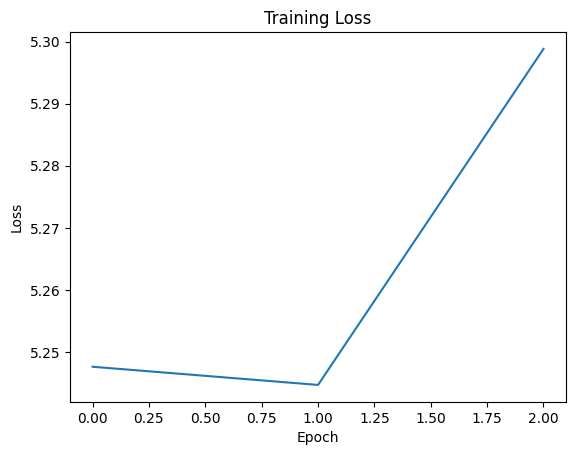

In [19]:
# Количество эпох
epochs = 5

# Список для хранения значений потерь на каждой эпохе
loss_values = []
best_loss = float('inf')
best_acc = 0.8

for epoch in range(epochs):
    model.train()
    total_loss = 0

    # Используйте tqdm для отображения прогресса
    for batch in tqdm(train_data_loader, desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_data_loader)
    loss_values.append(avg_train_loss)

    print(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}")

    model.eval()
    predictions , true_labels = [], []

    for batch in tqdm(test_data_loader, desc=f"Validation Epoch {epoch+1}"):
        with torch.no_grad():
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            logits = logits.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()
            
            print(logits)
            predictions.extend(np.argmax(logits, axis=1).flatten())
            true_labels.extend(label_ids.flatten())

    acc = accuracy_score(true_labels, predictions)
    rec = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')

    print(f"Accuracy: {acc:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}")

    # Ранняя остановка по потерям на валидации
    if avg_train_loss > best_loss:
        print("Early stopping due to increase in validation loss")
        break

    # Ранняя остановка по точности на валидации
    if acc >= best_acc:
        print("Early stopping due to reaching target accuracy")
        break

    best_loss = avg_train_loss

plot_loss(loss_values)

In [20]:
# plot_loss(loss_values)
